<a href="https://colab.research.google.com/github/ricrichardthomas1/info501/blob/main/pyTesseract%26YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyTesseract + YOLO for table extraction**  

This notebook uses the pyTesseract + YOLO model method of table extraction from scanned pdfs

[Source: Medium article](https://medium.com/mlearning-ai/document-intelligence-series-part-1-table-detection-with-yolo-1fa0a198fd7#:~:text=In%20order%20to%20extract%20the,to%20pytesseract%20for%20information%20extraction.)

# Installing dependencies

In [1]:
# Installing tesseract in system
#!sudo apt install tesseract-ocr

# Installing required dependencies
!pip install pytesseract transformers ultralyticsplus==0.0.23 ultralytics==8.0.21

!pip install pdf2image # need it to convert pdfs to image files
#!apt-get update
#!apt-get install poppler-utils

     ---------------------------------------- 7.2/7.2 MB 16.4 MB/s eta 0:00:00
     ------------------------------------- 261.4/261.4 kB 16.7 MB/s eta 0:00:00
     -------------------------------------- 105.4/105.4 kB 6.3 MB/s eta 0:00:00
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
     ---------------------------------------- 6.0/6.0 MB 5.7 MB/s eta 0:00:00
     -------------------------------------- 162.6/162.6 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 5.3 MB/s eta 0:00:00
     ------------------------------------- 252.8/252.8 kB 16.2 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 2.5 MB/s eta 0:00:00
     -------------------------------------- 277.7/277.7 kB 8.6 MB/s eta 0:00:00
     ---------------------------------------- 130.2/130.2 kB ? eta 0:00:00
     ------------------------------------- 781.3/781.3 kB 51.4 MB/s eta 0:00:00
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)


ERROR: Invalid requirement: '#'


# Importing Packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import pytesseract
from pytesseract import Output

from ultralyticsplus import YOLO, render_result
from PIL import Image
import os
import cv2
from pdf2image import convert_from_path
import shutil

In [2]:
os.getcwd()

'c:\\Users\\Richard\\Documents\\GitHub\\info501'

# Loading Image

In [4]:
dir_name = 'pages'
dir_path = os.path.join(os.getcwd(),dir_name)
if os.path.exists(dir_path):
  shutil.rmtree(dir_path)


images = convert_from_path('waimate_sample.pdf')
os.makedirs('pages')
for i in range(len(images)):
  images[i].save('pages/page'+str(i)+'.jpg', 'JPEG')

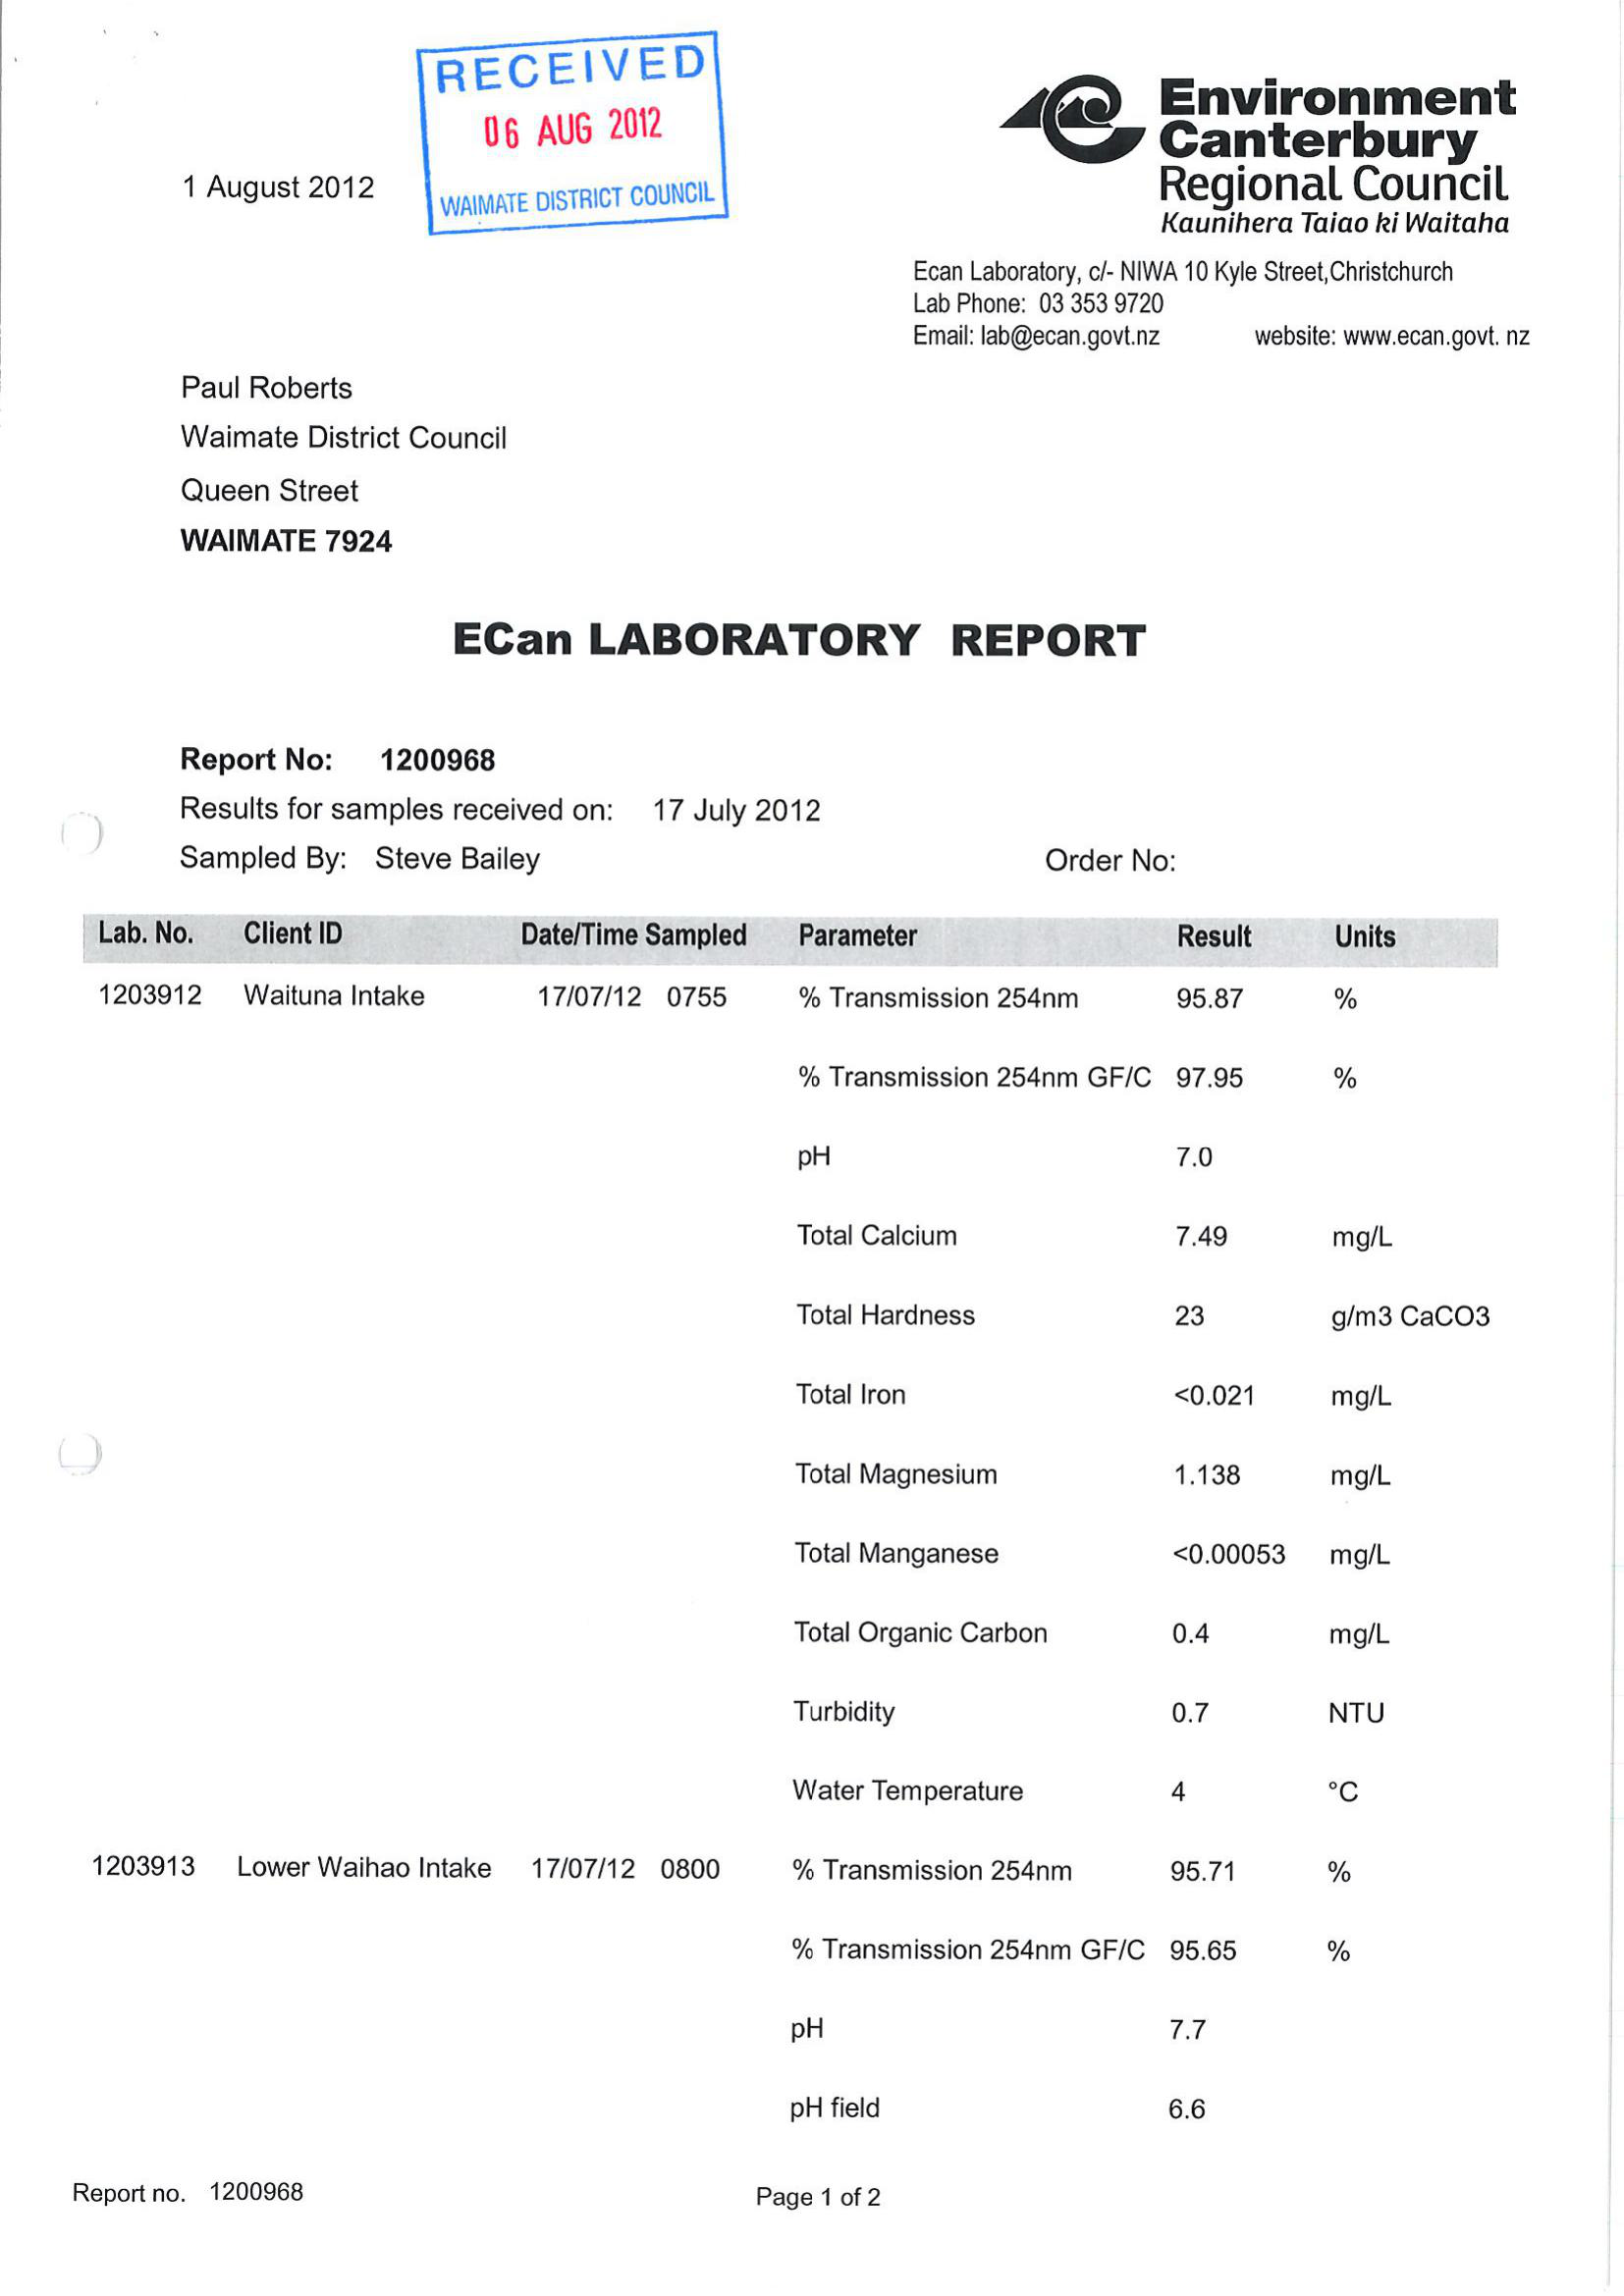

In [6]:
## Image downloaded from below link
# https://stackoverflow.com/questions/50829874/how-to-find-table-like-structure-in-image

image = './pages/page0.jpg'
image2 = './sample_image.png'
img = Image.open(image)
img

# Initialize YOLOv8m model

In [7]:
# load model
model = YOLO('keremberke/yolov8m-table-extraction')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# Detect Table

Ultralytics YOLOv8.0.21  Python-3.7.15 torch-1.13.1+cpu CPU
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs
0: 640x480 1 borderless, 901.5ms
Speed: 2.8ms pre-process, 901.5ms inference, 29.6ms postprocess per image at shape (1, 3, 640, 640)


Boxes:  tensor([[7.00000e+01, 8.32000e+02, 1.52700e+03, 2.32500e+03, 7.06384e-01, 1.00000e+00]])


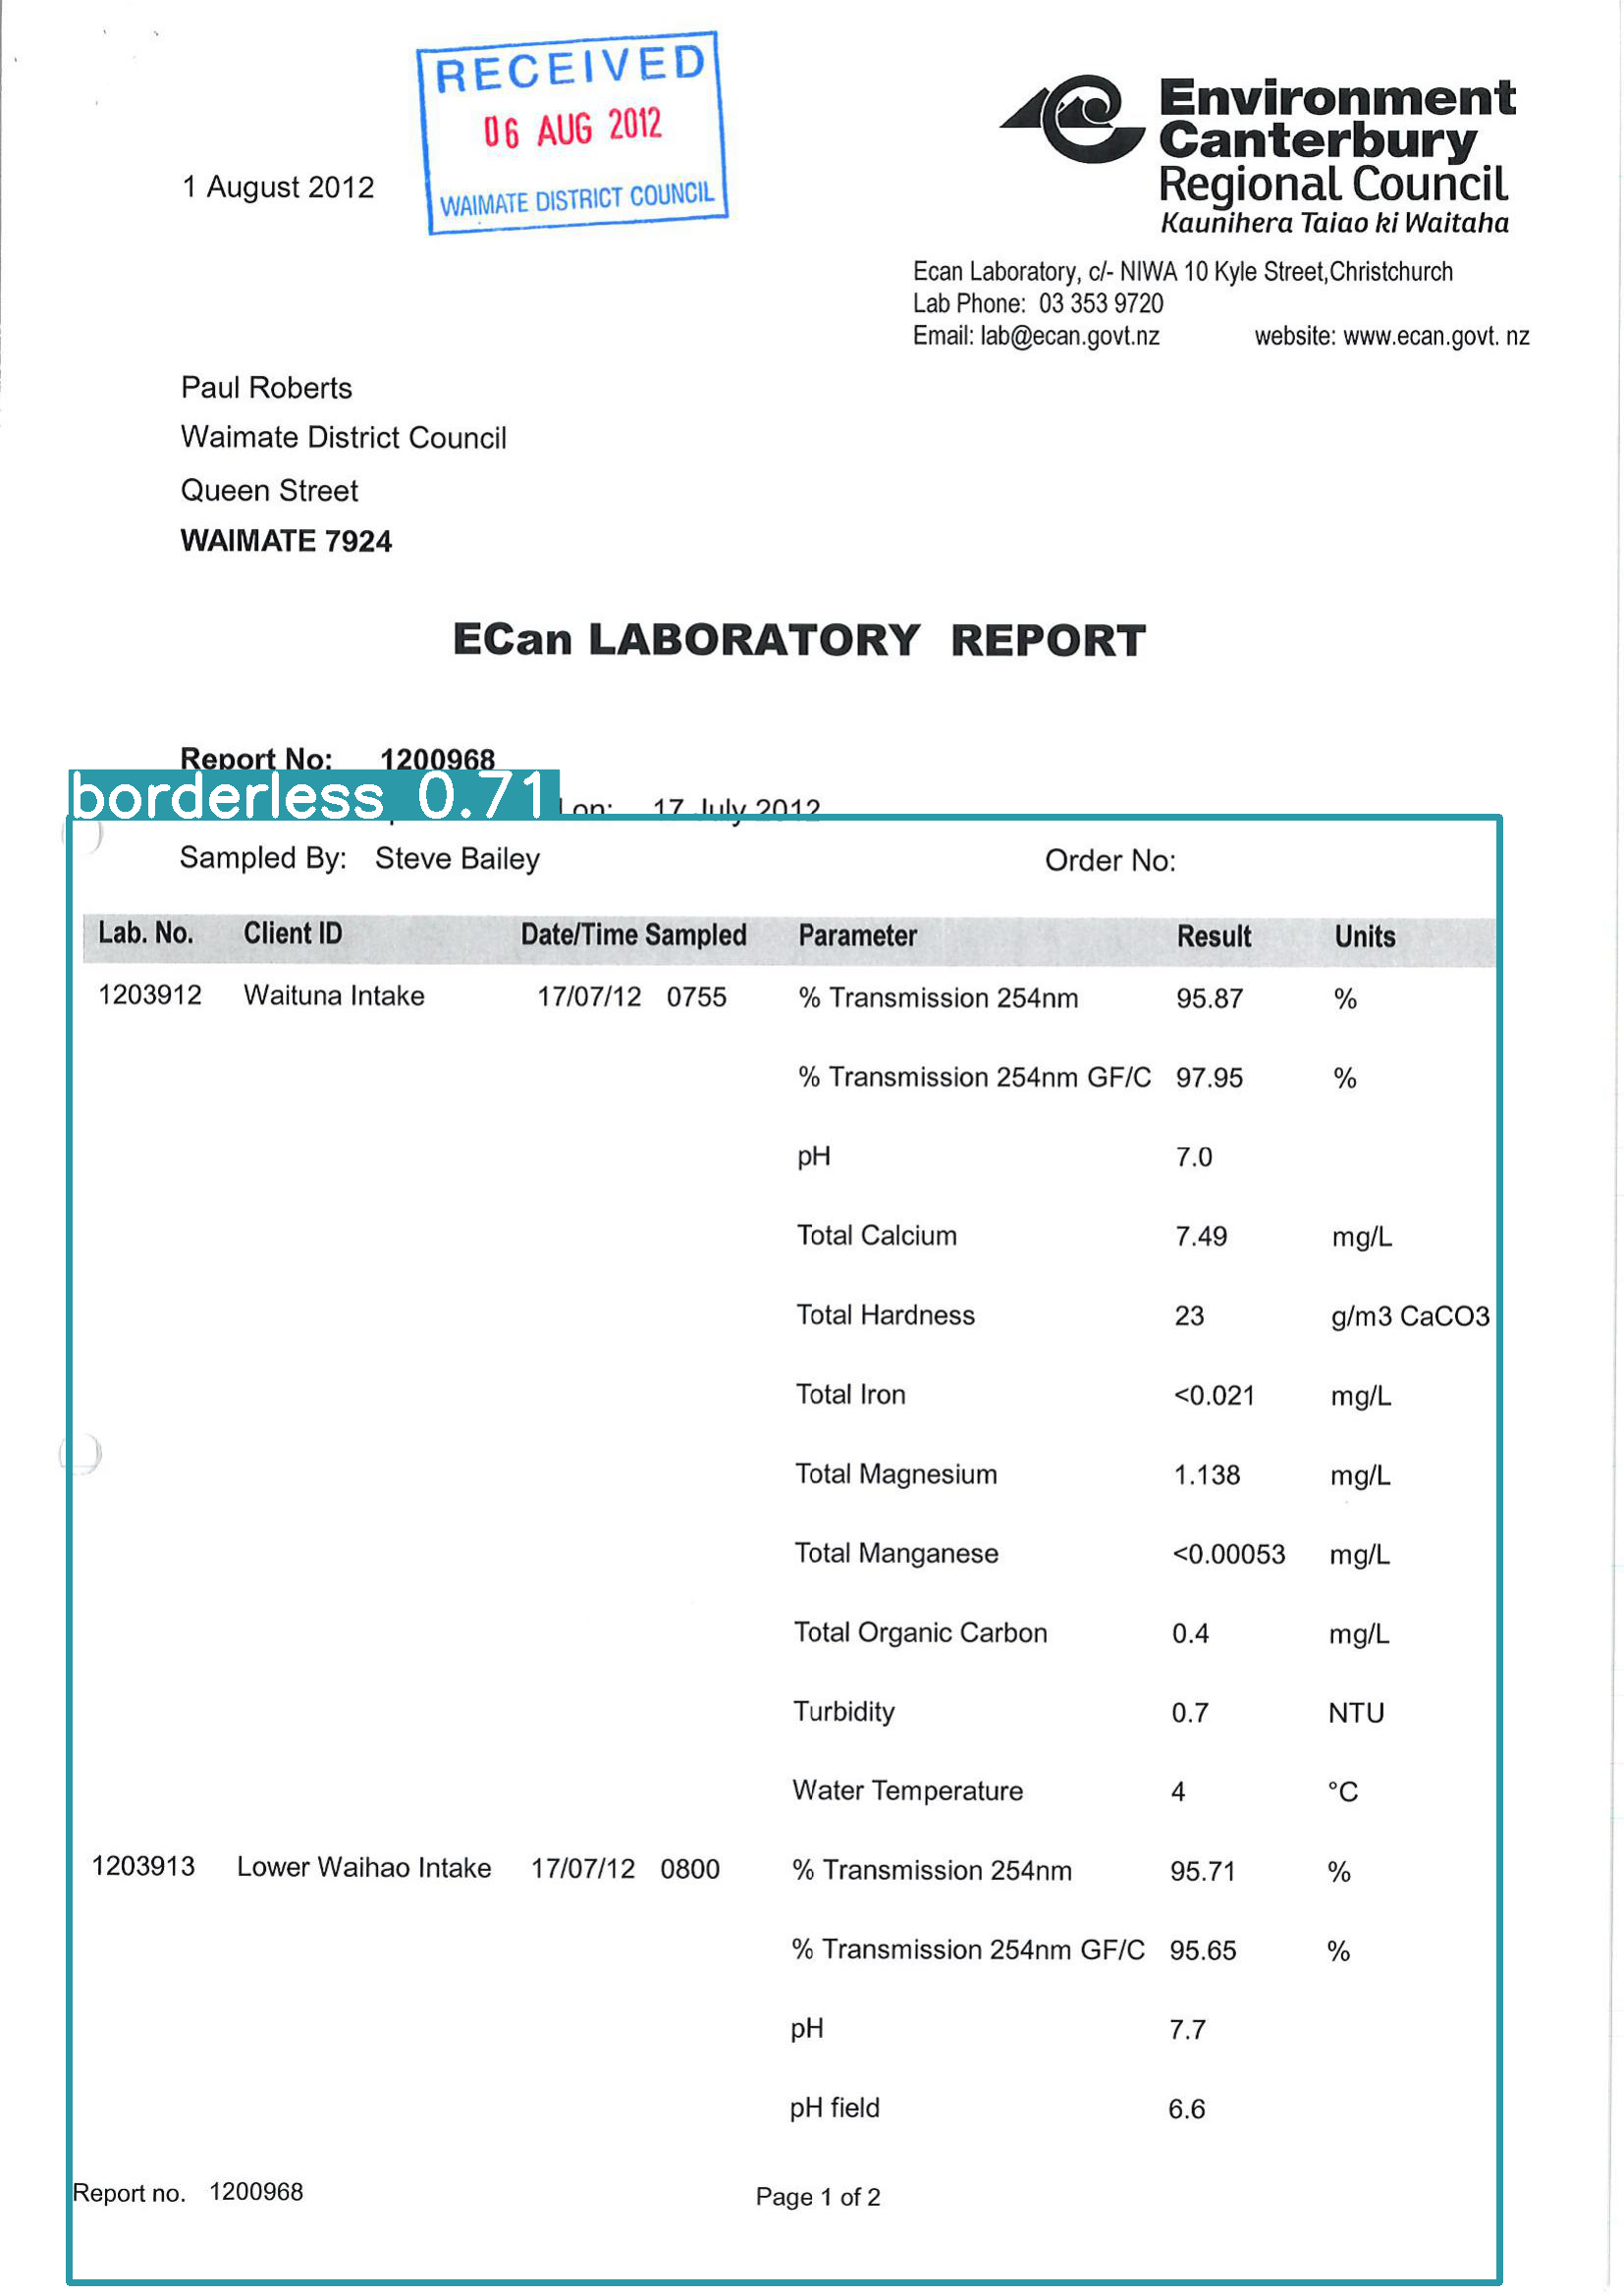

In [8]:
# perform inference
results = model.predict(img)

# observe results
print('Boxes: ', results[0].boxes)
render = render_result(model=model, image=img, result=results[0])
render

# Crop Table

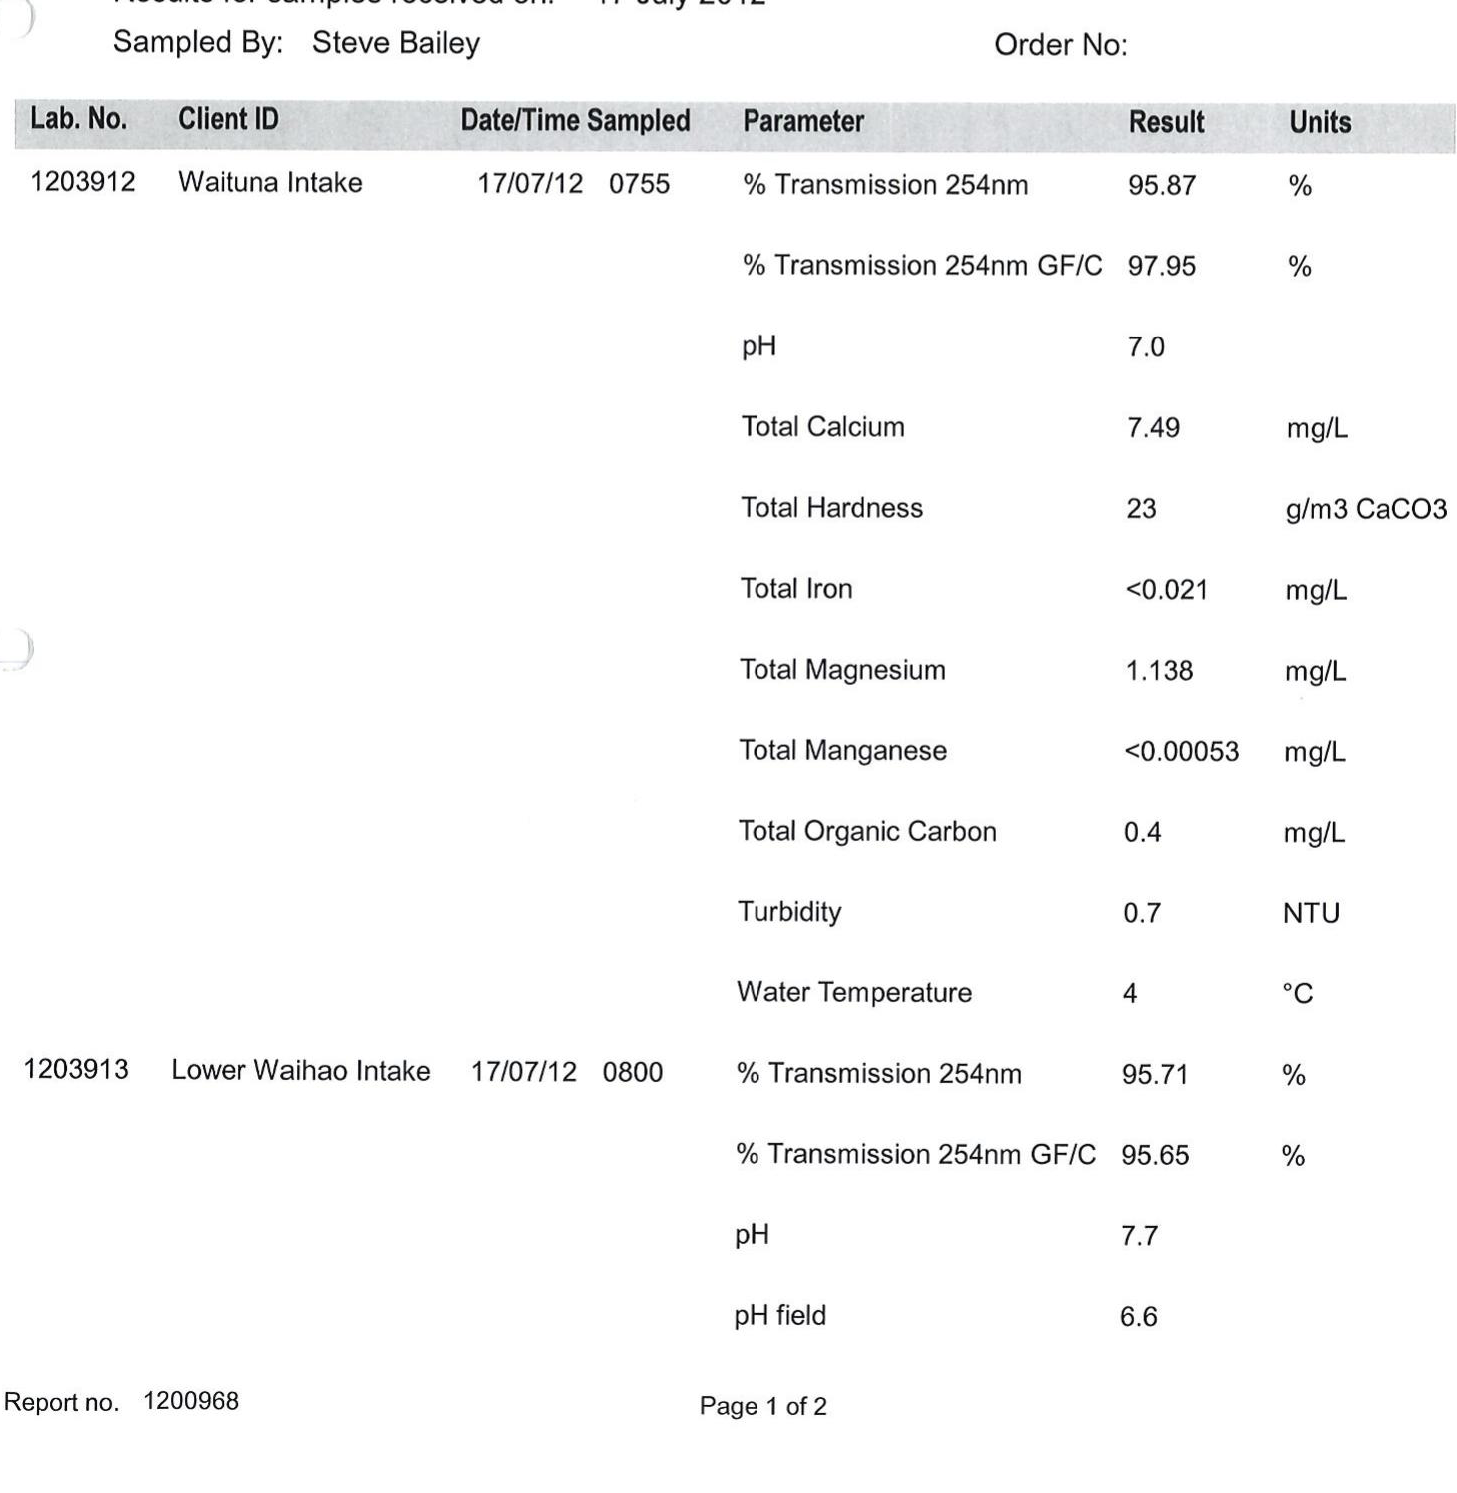

In [9]:
x1, y1, x2, y2, _, _ = tuple(int(item) for item in results[0].boxes.data.numpy()[0])
img = np.array(Image.open(image))
#cropping
cropped_image = img[y1:y2, x1:x2]
cropped_image = Image.fromarray(cropped_image)
cropped_image

# Perform OCR

In [10]:
ext_df = pytesseract.image_to_data(cropped_image, output_type=Output.DATAFRAME, config="--psm 1 --oem 3")

#ext_boxes = pytesseract.image_to_boxes(cropped_image, output_type=Output.DICT, config="--psm 6 --oem 3")
#ext_boxes['left']
#ext_string = pytesseract.image_to_string(cropped_image, output_type=Output.STRING, config="--psm 6 --oem 3")
#print(ext_string)

In [11]:
ext_df[ext_df.level == 5]

,level,page_num,block_num,par_num,line_num,...,top,width,height,conf,text
4,5,1,1,1,1,...,29,116,29,96.207825,Sampled
5,5,1,1,1,1,...,30,38,29,94.901482,By:
6,5,1,1,1,1,...,30,76,23,94.901482,Steve
7,5,1,1,1,1,...,31,79,29,96.799820,Bailey
11,5,1,2,1,1,...,105,47,24,96.413925,Lab.
12,5,1,2,1,1,...,105,37,24,96.035889,No.
14,5,1,2,1,2,...,170,103,21,78.799515,1203912
18,5,1,3,1,1,...,1058,103,21,95.143143,1203913
22,5,1,4,1,1,...,1392,73,23,96.556358,Report
23,5,1,4,1,1,...,1397,32,14,96.868172,no.


In [45]:
#h_boxes = []
#v_boxes = []

boxes = [[[ext_boxes['right'][i], ext_boxes['top'][i]],[ext_boxes['left'][i], ext_boxes['bottom'][i]]] for i in range(0,len(ext_boxes['left']))]
texts = [ext_boxes['char'][i] for i in range(0,len(ext_boxes['left']))]

#simage = cv2.imread('./canvas.JPG')
#cv2.rectangle(simage, (0,0), (0,10),(255,0,0),1)
#cv2.imwrite('./oimage.jpg', simage)
#oimage = cv2.imread('./oimage.jpg')
#Image.fromarray(simage)
#texts

In [51]:
image_boxes = img[y1:y2, x1:x2].copy()

In [52]:
for box,text in zip(boxes,texts):
    cv2.rectangle(image_boxes, (int(box[0][0]),int(box[0][1])), (int(box[1][0]),int(box[1][1])),(0,0,255),1)
    cv2.putText(image_boxes, text,(int(box[1][0]),int(box[0][1])),cv2.FONT_HERSHEY_SIMPLEX,1,(222,0,0),1)

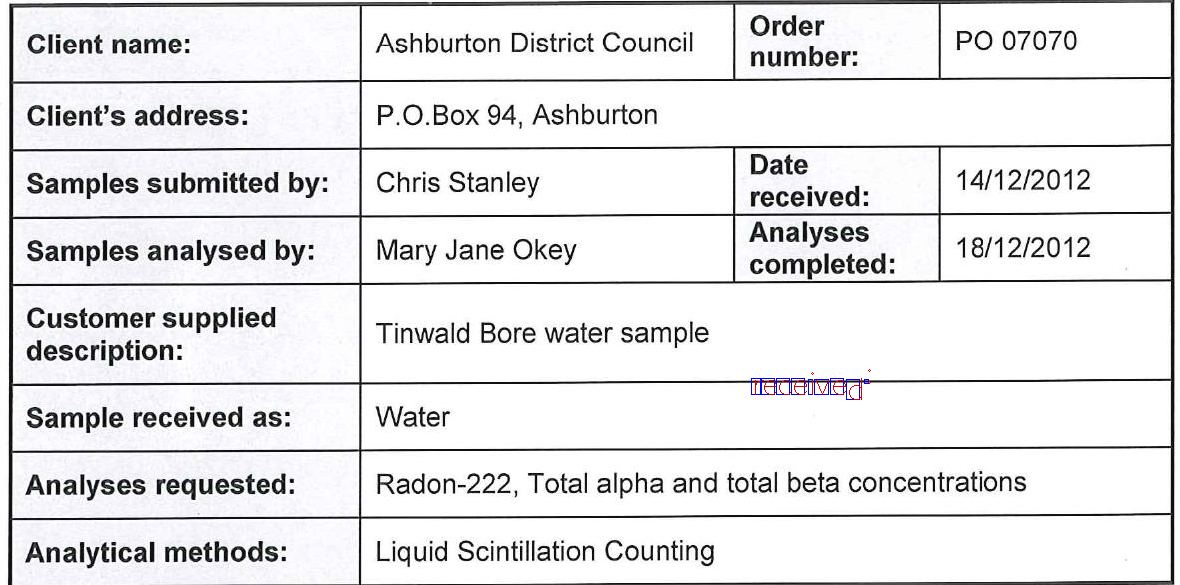

In [53]:
#cv2.imwrite('detections.jpg', image_boxes)
Image.fromarray(image_boxes)

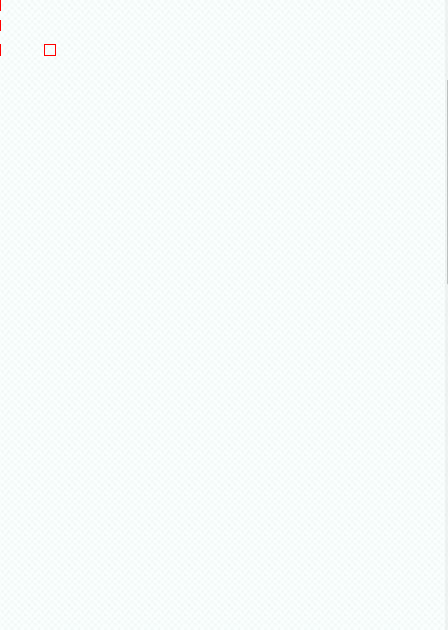

In [ ]:
#h_boxes = []
#v_boxes = []

#simage = cv2.imread('./canvas.JPG')
cv2.rectangle(simage, (0,0), (0,10),(255,0,0),1)
#cv2.imwrite('./oimage.jpg', simage)
#oimage = cv2.imread('./oimage.jpg')
Image.fromarray(simage)

In [1]:
horiz_boxes = []
vert_boxes = []

for box in boxes:
  x_h, x_v = 0,int(box[0][0])
  y_h, y_v = int(box[0][1]),0
  width_h,width_v = image_width, int(box[2][0]-box[0][0])
  height_h,height_v = int(box[2][1]-box[0][1]),image_height

  horiz_boxes.append([x_h,y_h,x_h+width_h,y_h+height_h])
  vert_boxes.append([x_v,y_v,x_v+width_v,y_v+height_v])

  cv2.rectangle(im,(x_h,y_h), (x_h+width_h,y_h+height_h),(0,0,255),1)
  cv2.rectangle(im,(x_v,y_v), (x_v+width_v,y_v+height_v),(0,255,0),1)


NameError: ignored

In [ ]:
#pytesseract.pytesseract.file_to_dict(pytesseract.image_to_string(cropped_image, output_type=Output.STRING, config="--psm 6 --oem 3"), '\t', 0)
!pip show opencv-python

Name: opencv-python
Version: 4.7.0.72
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, numpy, numpy, numpy
Required-by: dopamine-rl, imgaug, sahi, ultralytics


In [26]:
#Here is a possible Python code to use the pytesseract package to extract a dataframe from an image containing a table:

# Import the required modules
import cv2
import pytesseract
import pandas as pd

# Read the image file
img = cv2.imread('sample_image.png')

# Convert the image to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply some preprocessing to improve the OCR quality
# You can adjust the parameters according to your image
# For example, you can use thresholding, morphological operations, etc.
img = cv2.GaussianBlur(img, (3, 3), 0)
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Use pytesseract to get the data from the image
# You can specify the language, output format, and other options
data = pytesseract.image_to_data(img, lang='eng', output_type=pytesseract.Output.DICT)

# Create an empty dataframe to store the table data
df = pd.DataFrame()

# Loop through each word in the data
for i, word in enumerate(data['text']):
    # If the word is not empty
    if word != '':
        # Get the corresponding row, column, and confidence values
        row = data['line_num'][i]
        col = data['block_num'][i]
        conf = data['conf'][i]

        # Append the word, row, column, and confidence to the dataframe
        df = df.append({'word': word, 'row': row, 'col': col, 'conf': conf}, ignore_index=True)

# Sort the dataframe by row and column
df = df.sort_values(by=['row', 'col'])

# Group the dataframe by row and join the words
df = df.groupby('row')['word'].apply(lambda x: ' '.join(x)).reset_index()

# Print the dataframe
print(df)

"""Source: Conversation with Bing, 7/12/2023
(1) pytesseract · PyPI. https://pypi.org/project/pytesseract/.
(2) madmaze/pytesseract: A Python wrapper for Google Tesseract - GitHub. https://github.com/madmaze/pytesseract.
(3) Installing Tesseract, PyTesseract, and Python OCR packages on your .... https://pyimagesearch.com/2021/08/16/installing-tesseract-pytesseract-and-python-ocr-packages-on-your-system/.
(4) python - Extract tabular data from images - Stack Overflow. https://stackoverflow.com/questions/59735033/extract-tabular-data-from-images.
(5) python - How to convert or extract a table from an image using .... https://stackoverflow.com/questions/61418907/how-to-convert-or-extract-a-table-from-an-image-using-tesseract.
(6) Extracting tables from images in Python | Better Programming. https://betterprogramming.pub/extracting-tables-from-images-in-python-made-easy-ier-3be959555f6f.
(7) python - How to extract tables from Image - Stack Overflow. https://stackoverflow.com/questions/71115844/how-to-extract-tables-from-image.
(8) python - How to extract tables in Images - Stack Overflow. https://stackoverflow.com/questions/71109670/how-to-extract-tables-in-images."""

     row                                               word
0    1.0  Fluoridation status                           ...
1    2.0      (2013 Census Data WaterTreatment} HFA) Dos...
2    3.0  adjusted to provide plant] (Waiuku) receiving ...
3    4.0  Ardmore 350 2010 — 2022 Waiuku Road (Waiuku) 1...
4    5.0       Waikato 175 2010 — 2022 Victoria Avenue 0.96
5    6.0                      Waikato A Phase 1 50 (Waiuku)
6    7.0                Huia 126 2010 — 2022 Warkworth 3.24
7    8.0     Waitakere 20 4331503 2010 — 2022 Wellsford 1.2
8    9.0  Pukekohe* 6 2021 — 2022 Snells/Algies 1.44 ow ...
9   10.0                                   Helensville 1.32
10  11.0                                  Huia Village 0.35
11  12.0                                       Muriwai 0.24
12  13.0                                               = oe


'Source: Conversation with Bing, 7/12/2023\n(1) pytesseract · PyPI. https://pypi.org/project/pytesseract/.\n(2) madmaze/pytesseract: A Python wrapper for Google Tesseract - GitHub. https://github.com/madmaze/pytesseract.\n(3) Installing Tesseract, PyTesseract, and Python OCR packages on your .... https://pyimagesearch.com/2021/08/16/installing-tesseract-pytesseract-and-python-ocr-packages-on-your-system/.\n(4) python - Extract tabular data from images - Stack Overflow. https://stackoverflow.com/questions/59735033/extract-tabular-data-from-images.\n(5) python - How to convert or extract a table from an image using .... https://stackoverflow.com/questions/61418907/how-to-convert-or-extract-a-table-from-an-image-using-tesseract.\n(6) Extracting tables from images in Python | Better Programming. https://betterprogramming.pub/extracting-tables-from-images-in-python-made-easy-ier-3be959555f6f.\n(7) python - How to extract tables from Image - Stack Overflow. https://stackoverflow.com/question